In [ ]:
# LIBRARIES
import itertools
import os

import corner
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns

from model_utils import (
    calculate_flux_err,
    fit_parabolic_LLS,
    flux_to_magnitude,
    isolate_peak_data,
    magnitude_to_flux,
    model_flux,
    parabolic_bootstrap,
)

In [ ]:
# DATA MANAGMENT

# ==========================================
# USER CONFIGURATION
# ==========================================
# Change these values to analyze a different event
EVENT_YEAR = "2024"
EVENT_ID = "0393"  # Just the number
FIELD = "blg"  # usually 'blg' (Bulge)

# Construct Event Name and Filename
EVENT_NAME = f"OGLE-{EVENT_YEAR}-{FIELD.upper()}-{EVENT_ID}"
FILENAME = f"{EVENT_NAME}.dat"

# ==========================================
# DATA LOADING CHECK
# ==========================================
print(f"🔹 Initializing pipeline for: {EVENT_NAME}")

if not os.path.exists(FILENAME):
    print("\n" + "!" * 60)
    print(f"MISSING DATA FILE: '{FILENAME}'")
    print("!" * 60)
    print("⚠️  This analysis requires the photometric data file.")
    print("👉 Please download 'phot.dat' manually from: {EVENT_URL}")
    print("   (Look for the 'phot.dat' link in the Data section)")
    print(f"👉 Rename the file to '{FILENAME}' and place it in this folder.")
    print("!" * 60 + "\n")

    # Stop execution here if data is missing
    raise FileNotFoundError(
        f"Please download the data for {EVENT_NAME} before proceeding."
    )

else:
    print(f"✅ Data file '{FILENAME}' found.")
    try:
        data = np.loadtxt(FILENAME, dtype=float)
        print(f"   Loaded {len(data)} data points successfully.")
    except Exception as e:
        print(f"❌ Error reading file: {e}")

# Extracting measurements (time in HJD-2450000)
time = data[:, 0] - 2450000.0
mag = data[:, 1]
mag_err = data[:, 2]

# Baseline magnitude list (first 50 points)
mag_base_list = mag[:50]

# Baseline magnitude (mean of first 50 points)
mag_base = np.mean(mag_base_list)


🔹 Initializing pipeline for: OGLE-2024-BLG-0393
✅ Data file 'OGLE-2024-BLG-0393.dat' found.
   Loaded 2280 data points successfully.


### First Part:


In [6]:
# converting measurments to flux
flux = magnitude_to_flux(mag, mag_base)
flux_err = calculate_flux_err(mag, mag_err, mag_base)

# isolating data around peak
time_around_peak, mag_around_peak, mag_around_peak_err = isolate_peak_data(
    time, mag, mag_err, 4, 4
)

flux_around_peak = magnitude_to_flux(mag_around_peak, mag_base)
flux_around_peak_err = calculate_flux_err(
    mag_around_peak, mag_around_peak_err, mag_base
)

In [7]:
# PLOTTING STYLES
plt.rcParams.update(
    {
        "font.family": "serif",  # Use serif fonts (like Times)
        "font.size": 12,  # Base font size
        "xtick.direction": "in",  # Ticks point INWARD
        "ytick.direction": "in",  # Ticks point INWARD
        "xtick.top": True,  # Show ticks on top axis
        "ytick.right": True,  # Show ticks on right axis
        "xtick.major.size": 6,  # Length of major ticks
        "xtick.minor.visible": True,  # Show minor ticks
        "ytick.minor.visible": True,
        "axes.grid": False,  # Turn off Seaborn grid if active
    }
)

data_style = {
    "fmt": "o",  # Circle markers
    "mfc": "#000000",  # Marker Face Color: NONE (Hollow)
    "mec": "#000000",  # Marker Edge Color: Dark Greyish
    "ecolor": "#000000",  # Error bar color: Match marker edge
    "elinewidth": 0.8,  # Thin error bars
    "markersize": 4,  # Small markers
    "capsize": 2,  # No end caps on error bars
    "zorder": 1,
}

line_style = {"color": "blue", "linewidth": 1, "zorder": 2}


------------------------------
RESULTS FOR OGLE-2024-BLG-0393
------------------------------
Peak Time (t_0):       10449.9339 days
Impact Param (u_min):  0.1406
Einstein Time (t_E):   26.9992 days
Chi-Squared Red.:      0.7932
------------------------------


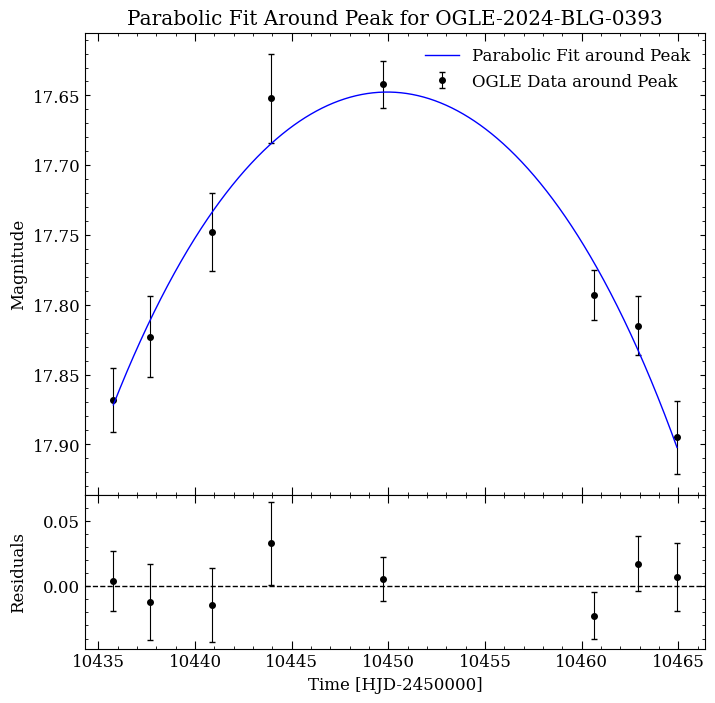

In [ ]:
# Plotting parabolic fit

(
    param,
    param_err,
    y_fit,
    chi_2_red,
    P_value,
    t_0_parabolic,
    u_min_parabolic,
    tau_parabolic,
) = fit_parabolic_LLS(
    y=flux_around_peak, y_error=flux_around_peak_err, x=time_around_peak, f_bl=1
)
# Nicely formatted output
print("-" * 30)
print(f"RESULTS FOR {EVENT_NAME}")
print("-" * 30)
print(f"Peak Time (t_0):       {t_0_parabolic:.4f} days")
print(f"Impact Param (u_min):  {u_min_parabolic:.4f}")
print(f"Einstein Time (t_E):   {tau_parabolic:.4f} days")
print(f"Chi-Squared Red.:      {chi_2_red:.4f}")
print("-" * 30)
# Plotting fit:
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, sharex=True, gridspec_kw={"height_ratios": [3, 1]}, figsize=(8, 8)
)
ax1.invert_yaxis()
ax1.errorbar(
    time_around_peak,
    mag_around_peak,
    mag_around_peak_err,
    **data_style,
    label="OGLE Data around Peak",
)
ax1.plot(
    np.linspace(min(time_around_peak), max(time_around_peak), 1000),
    flux_to_magnitude(
        y_fit(np.linspace(min(time_around_peak), max(time_around_peak), 1000)),
        mag_base=mag_base,
    ),
    **line_style,
    label="Parabolic Fit around Peak",
)
ax1.set_ylabel("Magnitude", fontsize=12)

# Draw the legend
ax1.legend(loc="upper right", frameon=False)
ax1.tick_params(labelbottom=False)


# Plotting residuals:
ax2.errorbar(
    time_around_peak,
    flux_to_magnitude(y_fit(time_around_peak), mag_base=mag_base) - mag_around_peak,
    mag_around_peak_err,
    **data_style,
)
ax2.axhline(0, color="black", linestyle="--", linewidth=1)
ax2.set_xlabel("Time [HJD-2450000]", fontsize=12)
ax2.set_ylabel("Residuals", fontsize=12)
plt.subplots_adjust(hspace=0)

# Align the y-labels nicely
fig.align_ylabels()
ax1.set_title(f"Parabolic Fit Around Peak for {EVENT_NAME}")
plt.savefig(f"Parabolic Fit Around Peak for {EVENT_NAME}.png", dpi=300)
plt.show()

t_0 average = 10449.883823313416 t_0 std = 0.83241409210187


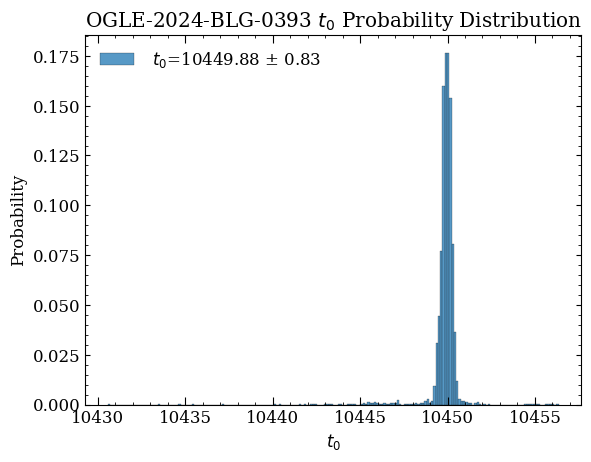

u_min average = 0.14070832574644593 u_min std = 0.0026226805813045657


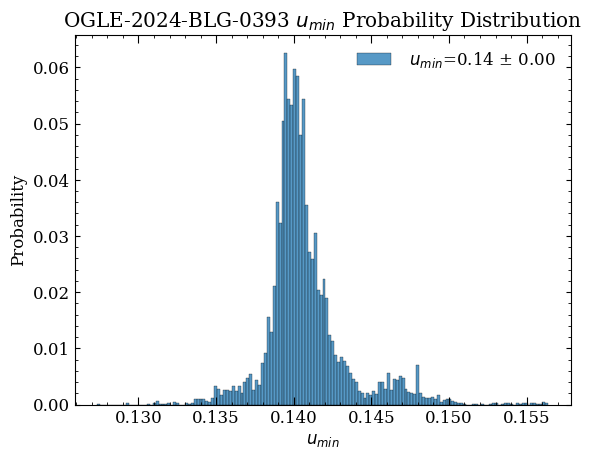

tau average = 27.26251204082578 tau std = 1.936857750221743


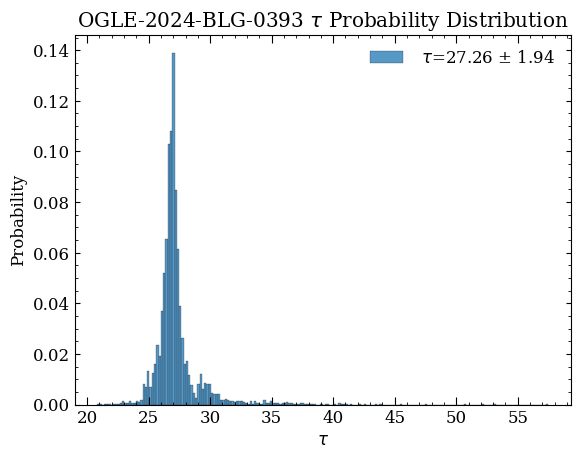

In [9]:
# PLOTTING BOOTSTRAP HISTOGRAMS
param_boot_array = parabolic_bootstrap(
    flux_around_peak, flux_around_peak_err, time_around_peak, f_bl=0.487
)


def plot_hist(data, name):
    """Plotting histogram of bootstrap parameter estimates and printing mean and std."""

    # calculating mean and std
    mean, std = np.mean(data), np.std(data)

    clean_name = (
        name.replace("$", "").replace("\\", "").replace("{", "").replace("}", "")
    )

    sns.histplot(
        data,
        stat="probability",
        label=f" {name}={mean:.2f} ± {std:.2f}",
        bins="auto",
    )

    # printing results
    print(f"{clean_name} average = {mean}", f"{clean_name} std = {std}")
    plt.xlabel(f"{name}")
    plt.ylabel("Probability")
    plt.title(f"{EVENT_NAME} {name} Probability Distribution")
    plt.legend(frameon=False)
    plt.savefig(f"boot strap {clean_name} {EVENT_NAME}.png")
    plt.show()


plot_hist(param_boot_array[0], r"$t_{0}$")
plot_hist(param_boot_array[1], r"$u_{min}$")
plot_hist(param_boot_array[2], r"$\tau$")

### Second Part:


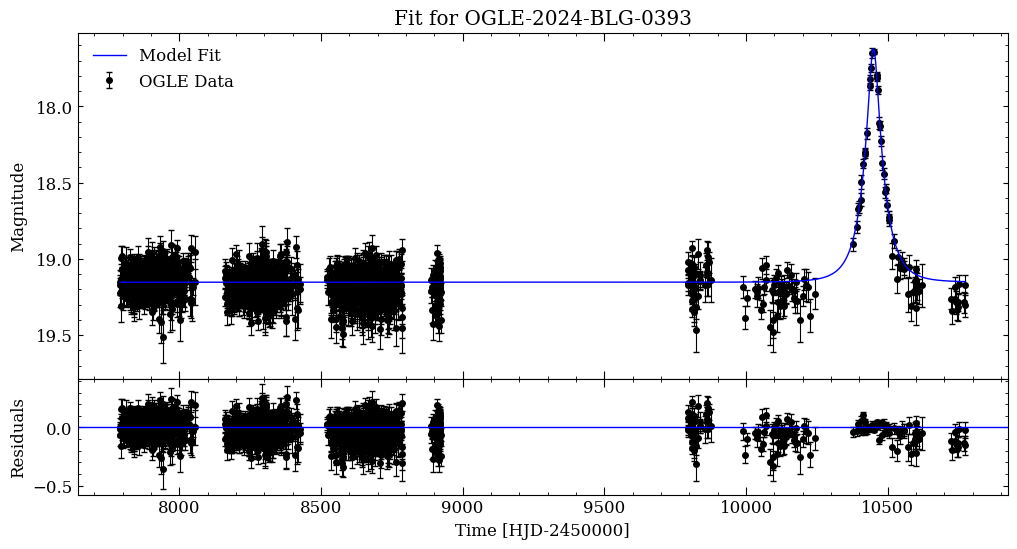

Fitted Parameters from Least Squares: [2.49199566e-01 6.92849429e+01 1.04495198e+04 1.00000000e+00]
Errors from Least Squares: [0.03538691 6.57170645 0.26448029 0.17064453]


In [12]:
# Curve fit

fit_params, fit_cov = sp.optimize.curve_fit(
    model_flux,
    time,
    flux,
    p0=[u_min_parabolic, tau_parabolic, t_0_parabolic, 1],
    sigma=flux_err,
    absolute_sigma=True,
    bounds=([0, 0, 0, 0], [np.inf, np.inf, np.inf, 1]),
)

# Plotting fit:
fig, (ax1, ax2) = plt.subplots(
    nrows=2,
    ncols=1,
    sharex=True,
    gridspec_kw={"height_ratios": [3, 1]},
    figsize=(12, 6),
)

ax1.invert_yaxis()
ax1.errorbar(
    time,
    mag,
    mag_err,
    **data_style,
    label="OGLE Data",
)

ax1.plot(
    np.linspace(min(time), max(time), 1000),
    flux_to_magnitude(
        model_flux(np.linspace(min(time), max(time), 1000), *fit_params),
        mag_base=mag_base,
    ),
    **line_style,
    label="Model Fit",
)

ax1.set_ylabel("Magnitude", fontsize=12)


ax1.legend(frameon=False)
ax1.tick_params(labelbottom=False)


# Plotting residuals:
ax2.errorbar(
    time,
    flux_to_magnitude(model_flux(time, *fit_params), mag_base=mag_base) - mag,
    mag_err,
    **data_style,
)

ax2.axhline(0, **line_style)
ax2.set_xlabel("Time [HJD-2450000]", fontsize=12)
ax2.set_ylabel("Residuals", fontsize=12)
plt.subplots_adjust(hspace=0)

# Align the y-labels
fig.align_ylabels()
ax1.set_title(f"Fit for {EVENT_NAME}")

plt.savefig(f"Fit for {EVENT_NAME}.png", dpi=300)
plt.show()


fit_param_errors = np.sqrt(np.diag(fit_cov))
print(f"Fitted Parameters from Least Squares: {fit_params}")
print(f"Errors from Least Squares: {fit_param_errors}")


Running grid search on 1500625 points...


c:\Users\zivsh\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\corner\core.py:921: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  return ax.set_xlim(new_xlim)
c:\Users\zivsh\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\corner\core.py:928: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  return ax.set_ylim(new_ylim)
c:\Users\zivsh\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\corner\core.py:928: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  return ax.set_ylim(new_ylim)


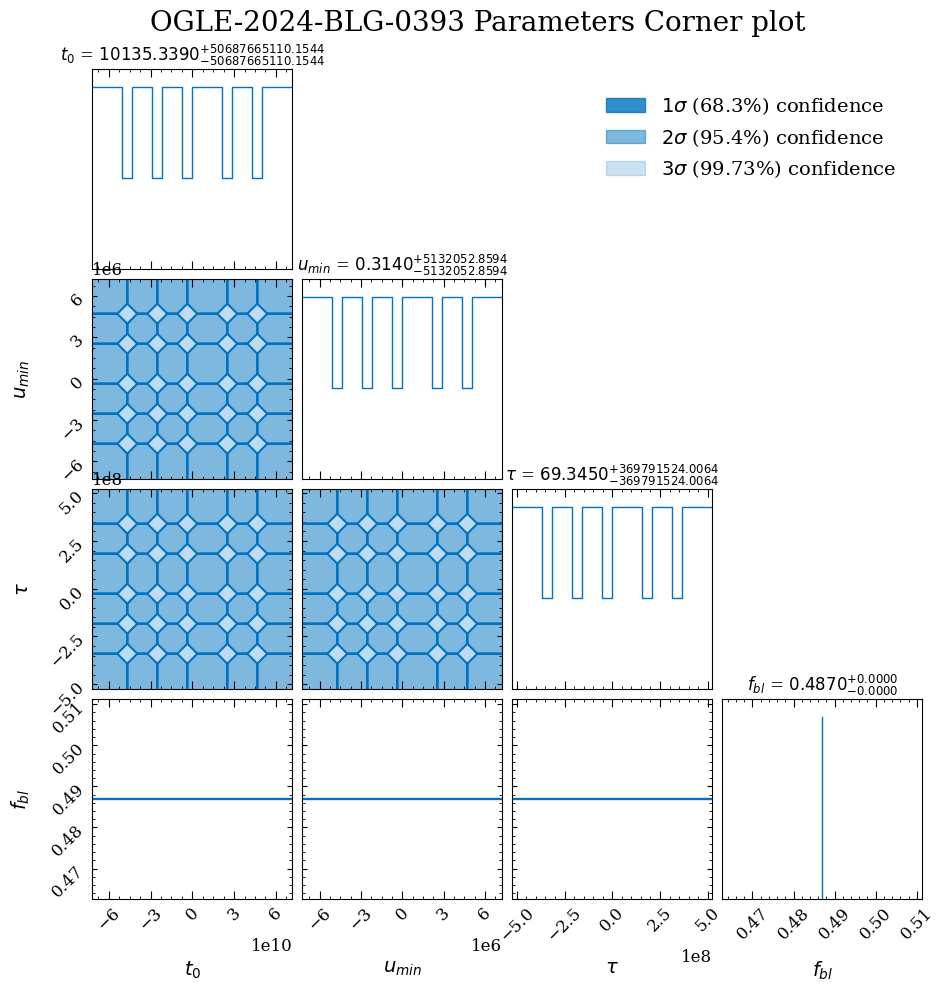

In [11]:
# Corner plot

# ---------------------------------------------------------
# 3. CREATE THE GRID
# ---------------------------------------------------------
res = 35
sigma_range = 3  # How far to search (in sigmas)

# ranges centered on best fit
t_0_range = np.linspace(
    fit_params[0] - sigma_range * fit_param_errors[0],
    fit_params[0] + sigma_range * fit_param_errors[0],
    res,
)
u_min_range = np.linspace(
    fit_params[1] - sigma_range * fit_param_errors[1],
    fit_params[1] + sigma_range * fit_param_errors[1],
    res,
)
tau_range = np.linspace(
    fit_params[2] - sigma_range * fit_param_errors[2],
    fit_params[2] + sigma_range * fit_param_errors[2],
    res,
)
f_bl_range = np.linspace(
    fit_params[3] - sigma_range * fit_param_errors[3],
    fit_params[3] + sigma_range * fit_param_errors[3],
    res,
)

# ---------------------------------------------------------
# 4. LOOP AND CALCULATE
# ---------------------------------------------------------
print(f"Running grid search on {res**4} points...")
param_grid = []
chi2_list = []

for t0, u0, tau, fbl in itertools.product(
    t_0_range, u_min_range, tau_range, f_bl_range
):
    y_model = model_flux(time, t0, u0, tau, fbl)

    # Chi2 = Sum of (Residual / Error)^2
    chi2 = np.sum(((y_model - flux) / flux_err) ** 2)

    param_grid.append([t0, u0, tau, fbl])
    chi2_list.append(chi2)

# 5. PREPARE DATA
data_combined = np.column_stack((param_grid, chi2_list))
df = pd.DataFrame(data_combined, columns=["t_0", "u_min", "tau", "f_bl", "Chi2"])

# Likelihood Weights
min_chi2 = df["Chi2"].min()
df["delta_chi2"] = df["Chi2"] - min_chi2
df["weight"] = np.exp(-0.5 * df["delta_chi2"])

# Normalize weights
weights = np.array(df["weight"].values)
weights /= np.sum(weights)
data = df[["t_0", "u_min", "tau", "f_bl"]].values
labels = [r"$t_0$", r"$u_{min}$", r"$\tau$", r"$f_{bl}$"]

fig = corner.corner(
    data,
    weights=weights,
    labels=labels,
    color="#0072C1",
    show_titles=True,
    title_fmt=".4f",
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 14},
    bins=20,
    smooth=0,
    smooth1d=0,
    plot_datapoints=False,
    fill_contours=True,
    levels=[0.683, 0.954, 0.9973],
    range=[
        (
            fit_params[0] - sigma_range * fit_param_errors[0],
            fit_params[0] + sigma_range * fit_param_errors[0],
        ),
        (
            fit_params[1] - sigma_range * fit_param_errors[1],
            fit_params[1] + sigma_range * fit_param_errors[1],
        ),
        (
            fit_params[2] - sigma_range * fit_param_errors[2],
            fit_params[2] + sigma_range * fit_param_errors[2],
        ),
        (
            fit_params[3] - sigma_range * fit_param_errors[3],
            fit_params[3] + sigma_range * fit_param_errors[3],
        ),
    ],
    hist_kwargs={"linewidth": 1, "color": "#0072C1"},
)


fig.suptitle(f"{EVENT_NAME} Parameters Corner plot", fontsize=20, y=1.02)
# Create custom legend patches
patch1 = mpatches.Patch(
    color="#0072C1", alpha=0.8, label=r"$1\sigma$ (68.3%) confidence"
)
patch2 = mpatches.Patch(
    color="#0072C1", alpha=0.5, label=r"$2\sigma$ (95.4%) confidence"
)
patch3 = mpatches.Patch(
    color="#0072C1", alpha=0.2, label=r"$3\sigma$ (99.73%) confidence"
)

# bbox_to_anchor moves it relative to the whole figure
fig.legend(
    handles=[patch1, patch2, patch3],
    loc="upper right",
    fontsize=14,
    bbox_to_anchor=(0.95, 0.95),  # (x, y) coordinates (0-1)
    frameon=False,
)
plt.savefig(
    f"{EVENT_NAME} Parameter Distributions from Grid Search.png",
    bbox_inches="tight",
)
plt.show()